# Periodic boundaries


This tutorial will show how to implement Periodic boundary conditions (where particles that leave the domain on one side enter again on the other side) can be implemented in Parcels


In case you have a global model on a C-grid, then there is typically not much that needs to be done. The only thing you have to be aware of, is that there is no 'gap' between the longitude values on the right side of the grid and on the left side of the grid (modulo 360). In other words, that

```python
fieldset.U.lon[:, 0] >= fieldset.U.lon[:, -1]
```

This is the case for most [curvilinear NEMO model outputs on a C-grid](https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_curvilinear.html), so that periodic boundary conditions work out of the box, without any special code required.

For [Hycom models](https://github.com/OceanParcels/parcels/issues/1240), we have found that it can help to add an extra column of longitudes at the end of the longitude array:

```python
lon_c = np.expand_dims(fieldset.U.grid.lon[:, 0], axis=1)
fieldset.U.grid.lon = np.hstack((fieldset.U.grid.lon, lon_c))
```


In case of 'simple' models on an A-grid, the idea in Parcels is to do two things:

1. Extend the fieldset with a small 'halo'
2. Add a periodic boundary kernel to the `.execute`


We'll start by importing the relevant modules


In [1]:
import math
from datetime import timedelta as delta

import matplotlib.pyplot as plt
import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    download_example_dataset,
)

We import the Peninsula fieldset; note that we need to set `allow_time_extrapolation` because the Peninsula fieldset has only one time snapshot.


In [2]:
example_dataset_folder = download_example_dataset("Peninsula_data")
fieldset = FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula", allow_time_extrapolation=True
)

Extending the fieldset with a halo is very simply done using the `add_periodic_halo()` method. Halos can be added either in the zonal direction, the meridional direction, or both, by setting `zonal` and/or `meridional` to `True`.

But before we apply the halo, we first define two new fieldset constants `halo_east` and `halo_west`. They store the original zonal extend of the grid (so _before_ adding the halo) and will be used later in the `periodicBC` kernel.

**_Note that some hydrodynamic data, such as the global ORCA grid used in NEMO, already has a halo._** In these cases, **do not** extent the fieldset with the halo but only add the periodic boundary kernel, where you use the explicit values for halo_east and halo_west


In [3]:
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])

fieldset.add_periodic_halo(zonal=True)

The other item we need is a custom Kernel that can move the particle from one side of the domain to the other.


In [4]:
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

Now define a particle set and execute it as usual


In [5]:
pset = ParticleSet.from_line(
    fieldset, 
    pclass=JITParticle, 
    size=10, 
    start=(20e3, 3e3), 
    finish=(20e3, 45e3)
)

output_file = pset.ParticleFile(
    name="PeriodicParticle", 
    outputdt=delta(hours=1)
)

pset.execute(
    [AdvectionRK4, periodicBC],
    runtime=delta(hours=24),
    dt=delta(minutes=5),
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4periodicBC ==> /var/folders/x0/1qxj679n55zcybylvdsb4bxh0000gq/T/parcels-503/12fa8b467a329fcce1c37d12734f76bd_0.c


And finally plot the particle trajectories


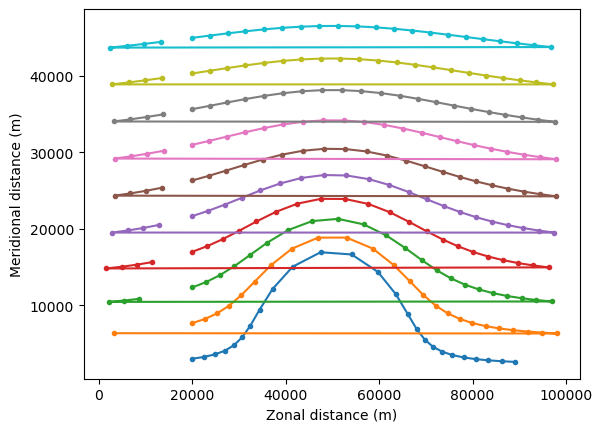

In [6]:
ds = xr.open_zarr("PeriodicParticle.zarr")

plt.plot(ds.lon.T, ds.lat.T, '.-')
plt.xlabel('Zonal distance (m)')
plt.ylabel('Meridional distance (m)')
plt.show()

We can see that the particles start at 20,000m, move eastward, and once they hit the boundary at 90,000m, they jump to the other side of the domain (the horizontal lines). So we have periodic boundary conditions!


As a note, one may ask "why do we need the halo? Why can't we use simply the `PeriodicBC` kernel?" This is because, if the particle is close to the edge of the fieldset (but still in it), `AdvectionRK4` will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure `AdvectionRK4` can access these values.
